# Quantum Monte Carlo (QMC)
## a basic demonstration

One module you may not have downloaded is autograd. If not, run the following:

In [ ]:
%pip install autograd

In [2]:
#Imports
import autograd.numpy as np #tricky!
import autograd
from numpy import random as rdm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats

## Monte Carlo sampling and integration

The most common use for Monte Carlo methods in science is the is the calculation of expectation values of high-dimensional functions $f$ over an analytically specified probability distribution. The basic process is as follows: 'sample' the distribution (i.e. create a series of points $\bf{X}_i$ with a density proportional to the probability density of the distribution), then take the average of $f(\bf{X}_i)$.

### Metropolis MCMC sampling

The most common sampling method is the 'Metropolis Markov Chain Monte Carlo' method (often called Metropolis MCMC), originally outlined by [Nicholas Metropolis et al. in 1953 for chemistry applications](https://en.wikipedia.org/wiki/Equation_of_State_Calculations_by_Fast_Computing_Machines). Below is a description and implementation of this algorithm to sample a probability distribution $P(\bf{X})$.

1. Begin with an initial point chosen at random $\bf{X_0}$, then make a random move from this point to a new point $\bf{X_1}$ according to a Gaussian distribution centered at $\bf{X_0}$.
2. Calculate the 'Metropolis acceptance probability': $$W(X_1|X_0) = \min \left(\frac{P(\bf{X_1})}{P(\bf{X_0})}, 1 \right)$$
3. With probability $W$, accept the move. If the move is not accepted, try a different move.
4. Repeat the process, now starting at $\bf{X_1}$ and moving to $\bf{X_2}$...
5. For the first few hundred moves, the 'equilibration' phase, do not save the points. After a while, the points should begin to stay within the bounds of the probability distribution $P(\bf{X})$, and you can save the points.

Below is an animation of the process: starting from the first point, a move is suggested and accepted, then another is suggested and rejected, before a final is suggested and accepted.

![MCMC algorithm animation](<./MCMC%20animation.gif>)

Below this algorithm is implemented in 2 functions: 

1. _move_ facilitates moves from $\bf{X_{i-1}}$ to $\bf{X_{i-1}}$
2. _sample_ organizes the sampling procedure

In [3]:
#Defining the 'move' function
def move(A, P, n, max_loop=5, stdv=2, dim=3):
    """
    Facilitates move from A to B, accepts and returns B
    OR rejects B and recursively starts over at A.
    This algorithm tends to work best moving only one 'particle'
    at a time.
    
    Args: 
        A: starting point
        P: probability distribution
        n: particle being moved.
        i, max_recursion: recursion trackers
        stdv: the standard deviation of each step size
        base_dim: number of dimensions of real space
                  in which the problem takes place
    
    """
    W = 0 #Setting up metropolis acceptance prob
    iteration=0
    acc = rdm.rand() #threshold required to accept sample on this move
    while (W < acc and iteration < max_loop):
        B = np.zeros(A.shape) #setting B to A raises issues
        B += A
        B[n] += stdv*stats.norm.rvs(size=(dim)) #random step

        W = P(np.array([B]))/P(np.array([A]))#Metropolis acceptance probability

    return B, W

In [4]:
#Defining 'sample' function

def sample(P, M, N, window=2, equilib_time=1000, dim=3):
    """
    This function samples a probability distribution using Metropolis
    Markov Chain Monte Carlo. 
    
    Args:
        P: probability distribution
        M: number of samples
        N: number of particles
        window: dimension of box in which the initial point is generated
        
    """
    
    #generate initial sample
    samples = window*(rdm.rand(1, N, dim)-0.5)
    
    #Equilibration phase
    for m in range(equilib_time):
        for n in range(N):
            samples[0], W = move(samples[0], P, n, dim=dim)
    
            
    #Begin accumulating
    for m in range(1, M):
        #starts next sample at previous sample's location
        samples = np.append(samples, [samples[m-1]], axis=0)
        for n in range(N):
            #moves it 1 particle at a time
            samples[m], W = move(samples[m], P, n, dim=dim) 
            
    return samples          

### Test of Metropolis MCMC algorithms

This algorithm is tested on the energy of a 2p-orbital of a hydrogen atom: $$P(r, \theta) = \Psi^2 = \left(\exp\left(-\frac{1}{a_0} \frac{r}{2}\right) r \cos(\theta) \right)^2$$

$$\left< H\right> = E\left(\frac{1}{\Psi}\left(-\frac{\hbar^2}{2m}\nabla^2 + \frac{ke^2}{r} \right)\Psi, P\right)$$
In spherical coordinates, where $a_0$ is the Bhor radius, $e$ is the electron charge, $m$ is the electron mass and $k$ is the Coulomb constant (all 1 in Hartree units). The expression $$\frac{1}{\Psi}\left(-\frac{\hbar^2}{2m}\nabla^2 + \frac{ke^2}{r} \right)\Psi$$ is very common in QMC methods, and is called the 'local energy' $E_l$.

In [7]:
#Defining some constants, as labeled above
a0 = 1
hbar = 1
e = 1
m = 1
k = 1

#Defining 2p orbital wave function
def p(X):
    """
    takes vector of form [[[x, y, z]], [[x,y,z]],...]
    
    returns probability amplitude
    
    """
    #defining necessary spherical coordinates
    r = np.sqrt(np.sum(X**2, axis=-1))
    
    theta = np.arccos(X[:,:,0]/r)

    return (np.e**(-1/a0 * r/2))*r*np.cos(theta)

#Defining 2p modulus squared as the probability distribution P
def P(X):
    return p(X)**2 


Below, I've also defined the functions necessary for calculating $E_l$. These will be relevant throughout this introduction.

In [5]:
#Defining Kinetic Energy
def T(R, psi):
    """
    Arguments:
        R: a position vector of form [[[x, y, z]], [[x,y,z]],...]
        psi: a wave function for one particle in 3D

    Returns the kinetic energy of psi at R
    
    """
    grad1 = autograd.elementwise_grad(psi)

    def grad1_i(x, i):
        return grad1(x)[:,:,i]
    
    grad2 = autograd.elementwise_grad(grad1_i)


    #Because of some weird stuff with autograd's elementwise grad,
    #We have to look at each element separately. 
    x_comp = grad2(R, i=0)[:,:,0]
    y_comp = grad2(R, i=1)[:,:,1]
    z_comp = grad2(R, i=2)[:,:,2]

    laplace = x_comp + y_comp + z_comp

        
    return -laplace * (hbar**2)/(2*m)

#Defining Coulomb potential
def V_c(R):
    """
    Takes a position vector of form [[[x, y, z]], [[x,y,z]],...]
    Returns the famous 1/r Coulomb potential evaluated at r
    
    """
    r = np.sqrt(np.sum(R**2, axis=-1))
    return -k*e**2/(r)

#Defining local energy.
def E_local(R, psi, V):
    """
    Args:
        R: a position vector of form [[[x, y, z]], [[x,y,z]],...]
        psi: a wave function for a particle in 3D
        V: a potential energy function

    Returns the local energy (as defined above)

    """

    #To make sure indeces line up, let's treat these separately:
    E = np.sum(T(R, psi), axis=-1)
    E /= np.sum(psi(R), axis = -1)
    E += np.sum(V(R), axis=-1)

    #Catches infinities at (0,0,0), copies nearby element
    where_nan = np.argwhere(np.isnan(E))
    for arg in where_nan:
        E[arg] = E[arg+1]

    return E


Finally, we're ready to test the Metropolis MCMC algorithm:

In [48]:
#A required local energy wrapper for 2p orbital
def p_E_local(R):
    return E_local(R, p, V_c)

p_samples = sample(P, 5000, 1)
p_energy = np.average(E_local(p_samples, p, V_c))

print(f'Calculated energy in Hartree units: {p_energy} Hartrees')
print(f'The actual energy of a p2 orbital in a Hydrogen atom is -0.125 Hartrees')

Calculated energy in Hartree units: -0.125 Hartrees
The actual energy of a p2 orbital in a Hydrogen atom is -0.125 Hartrees


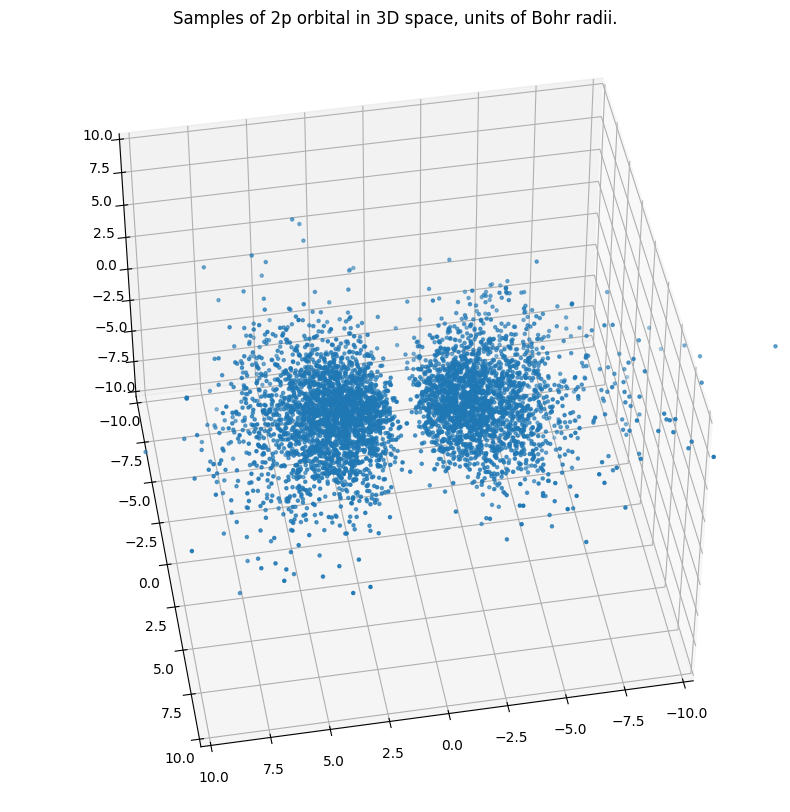

In [10]:
#Create plot of sample distribution
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.view_init(45,80)

window = 10
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('Samples of 2p orbital in 3D space, units of Bohr radii.')

ax.scatter(p_samples[:, 0, 0], p_samples[:, 0, 1], p_samples[:, 0, 2], marker = ".")

Which is exactly what the 2p orbital should look like! To me, the coolest part of this image is the visible lack of particles in the center (as should be the case given our expression for $\psi$). Physically, this is a consequence of the _angular momentum barrier_ that surpresses the wave function near the center of rotation for potentials satisfying $\lim_{r\rightarrow 0} r^2V(r) = 0$, a quantum version of the classical angular momentum barrier that, for instance, prevents planets from falling into stars.

## Variational Monte Carlo (VMC)

We finally arrive at Quantum Monte Carlo (QMC), with the goal (insofar as we are concerned) of finding ground state wave energies/wave functions. The key component of VMC is a 'variational wave function'---an analytic guess for the wave function function that depends on a one or more unknown parameters. The VMC algorithm changes these parameters until the variational wave function looks approximately like the ground state wave function. Generally, this means doing gradient descent to minimize either the expectation value of the energy (for obvious reasons) or the variance of the energy (as energy eigenstates have constant energies). 

The Monte Carlo part comes in when evaluating the expectation value of the energy or variance: $$\left<H\right> = \int dR \psi^\dagger E_0 \psi = \int dR \psi^\dagger H \psi$$
Meaning: $$E_0 = \frac{1}{\int dR \psi^\dagger \psi} \int dR \psi^\dagger H \psi = \frac{1}{\int dR \psi^\dagger \psi} \int dR \psi^\dagger \psi \frac{ H \psi}{\psi}$$

This part is basically a probability distribution: $$\frac{\psi^\dagger \psi}{\int dR \psi^\dagger \psi}$$ 

So we can sample it and use MCMC to calculate the expectation value of: $$\frac{ H \psi}{\psi}$$ which is just the local energy from before! One note -- the wave function don't need to be normalized, as we divide them out in the end anyway. We'll start by defining some helpful functions.

In [11]:
def evaluate(a, psi_var, V, M=500):
    """
    This evaluates the energy of a wave function
    psi_var(X, a) with variational parameter 'a'

    args:
        a: a variational parameter for the wave function (can be vector)
        psi_var: a variational wave function dependent on a
        V: a potential function
        M: number of samples at each evaluation

    Returns the expectation value of the Hamiltonian
    
    """
    
    #some aux functions of use:
    def psi_wrapper(X):
        #turns psi dependent on 'a' into a non-'a'-dependent function
        return psi_var(X, a)
    
    def P(X):
        #gives a probability distribution from |psi|^2
        return (psi_var(X, a))**2
    
    #Samples P
    samples = sample(P, M, 1)
    
    #expectation value of E 
    E =  np.sum(E_local(samples, psi_wrapper, V))/M

    return E

We'll also be solving a very simple problem -- the ground energy of a hydrogen atom. We'll be using a variational wave function with one parameter: $$\Psi(a, r) \propto \exp(-r) + a\psi_{2p}$$

In [12]:
#A superposition of 1s and 2p eigenstates
def psi(X, a):
    r = np.sqrt(np.sum(X**2, axis=-1))
    return np.e**(-r) + a * p(X) #p is the 2p wave function from before

First, let's look at the landscape of this wave function w.r.t the variational parameter. I.e., how does $\left<H\right>$ depend on $a$? (This may take a moment.)


In [14]:
#Calculating the full landscape:

a_s = np.linspace(-1, 1, 40)
E_s = np.zeros(40)

for i in range(40):
    E_s[i] = evaluate(a_s[i], psi, V_c, M=500)
    print(f'{a_s[i]}, {E_s[i]}')
    


-1.0, -0.14955284461041518
-0.9487179487179487, -0.15393957357489854
-0.8974358974358975, -0.1483652562037727
-0.8461538461538461, -0.1405828840346956
-0.7948717948717949, -0.14288964407193266
-0.7435897435897436, -0.16743996593766297
-0.6923076923076923, -0.16080869960583652
-0.641025641025641, -0.16424926530666709
-0.5897435897435898, -0.18195147020972097
-0.5384615384615385, -0.175955836199974
-0.4871794871794872, -0.1835947557081303
-0.4358974358974359, -0.21021285498361428
-0.3846153846153846, -0.22523572534896516
-0.33333333333333337, -0.2609431989800174
-0.28205128205128205, -0.30654032887991917
-0.23076923076923084, -0.3234080548157501
-0.17948717948717952, -0.34524065402286136
-0.1282051282051282, -0.3992479370203372
-0.07692307692307698, -0.4038920799920858
-0.02564102564102566, -0.5001768140102347
0.02564102564102555, -0.49018585956575156
0.07692307692307687, -0.4727156679708936
0.1282051282051282, -0.39832372017883577
0.17948717948717952, -0.3482303023668498
0.2307692307692

Text(0.5, 1.0, "Energy landscape -- how does the energy depend on 'a'? ")

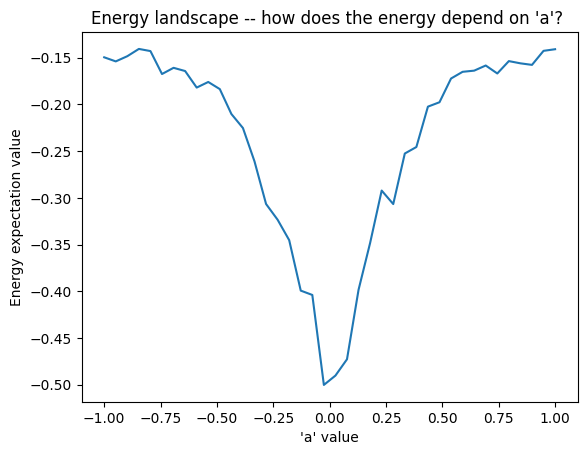

In [15]:
#Plotting landscape
plt.plot(a_s, E_s)
plt.xlabel('\'a\' value')
plt.ylabel('Energy expectation value')
plt.title('Energy landscape -- how does the energy depend on \'a\'? ')

As we can see, there's a clear minimum at $a=0$, which corresponds to the ground state energy. Now, we can do simple gradient descent with autograd (this also takes a moment):

In [37]:

#Setting up optimization tracking arrays; 
#this way I don't have to deal with appending
a_optimization = (rdm.rand(20)-0.5)
#a is only randomized at first, the subsequent a values are updated later
grads = np.zeros(20)
E_s_optimization = np.zeros(20)
grad_evaluate = autograd.grad(evaluate)

#Iterate energy
for i in range(19):
    #Get gradient
    grads[i] = grads[i] = grad_evaluate(a_optimization[i], psi, V_c, M=1000)
    #Update a, descending gradient (multiplied by 0.2 to prevent too large of an update)
    a_optimization[i+1] = a_optimization[i]-grads[i]*0.2
    #Update E
    E_s_optimization[i] = evaluate(a_optimization[i+1], psi, V_c, M=100)
    print(f'Iteration {i}: a = {a_optimization[i]}, grad = {grads[i]}, E = {E_s_optimization[i]}')


Iteration 0: a = 0.22312169908120005, grad = 0.06455516450999751, E = -0.29729564589156227
Iteration 1: a = 0.21021066617920056, grad = 0.06387109504992519, E = -0.39104524062824675
Iteration 2: a = 0.19743644716921552, grad = 0.17060778129060358, E = -0.40448906388709477
Iteration 3: a = 0.1633148909110948, grad = 0.02962396474497736, E = -0.38487588417151486
Iteration 4: a = 0.15739009796209932, grad = 0.05209910015110672, E = -0.3618121824872317
Iteration 5: a = 0.14697027793187797, grad = 0.019441480722667326, E = -0.41309514472898856
Iteration 6: a = 0.14308198178734452, grad = 0.12884868234843583, E = -0.32306214443951226
Iteration 7: a = 0.11731224531765735, grad = 0.18967825864280835, E = -0.4906877718873806
Iteration 8: a = 0.07937659358909568, grad = 0.1503616058284332, E = -0.48463704064389546
Iteration 9: a = 0.04930427242340904, grad = 0.09235597846075518, E = -0.49886539056505924
Iteration 10: a = 0.030833076731258003, grad = 0.11326648373261987, E = -0.4980378360826939
I

Text(0, 0.5, 'Calculated energy (Hartrees)')

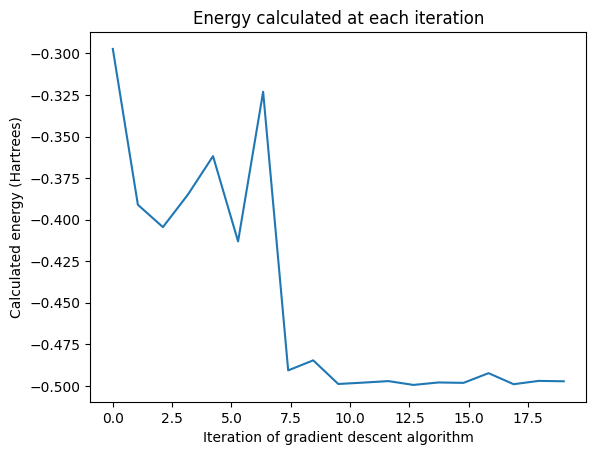

In [38]:
#Plotting progress of optimization over iterations

i_s = np.linspace(0,19,19)
plt.plot(i_s, E_s_optimization[:19])
plt.title('Energy calculated at each iteration')
plt.xlabel('Iteration of gradient descent algorithm')
plt.ylabel('Calculated energy (Hartrees)')

As we can see, even this proof of concept method can identify an accurate value of $a_0 \approx 0$ and $E_0 \approx -0.5$ Hartrees.